In [15]:
import numpy as np
from astropy.table import Table, join
from astropy.stats import sigma_clip

# Главная таблица
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')

# Таблица с фото-z
t_photo = Table.read('HSC_SSP_zphoto.fits')

# Оставляем только нужные столбцы в t_photo
t_photo = t_photo[['object_id', 'z_photo']]

# Фильтрация исходной таблицы
z_min = 0.02
z_max = 1.4

t_hsc = t_hsc_[((t_hsc_['z'] > z_min) & (t_hsc_['z'] < z_max) & 
                (t_hsc_['g_kronflux_mag'] > 0) & 
                (t_hsc_['r_kronflux_mag'] > 0) & 
                (t_hsc_['i_kronflux_mag'] > 0) & 
                (t_hsc_['z_kronflux_mag'] > 0) & 
                (t_hsc_['y_kronflux_mag'] > 0) & 
                (t_hsc_['zwarn'] == 0))]

# JOIN по object_id
t = join(t_hsc, t_photo, keys='object_id', join_type='inner')

print("Количество объектов после join:", len(t))

# Бины по r
r_bins = np.arange(17, 26, 1)

# Сюда собираем результаты
rows = {
    "r_min": [],
    "r_max": [],
    "N_galaxies": [],
    "meandz": []
}

for i in range(len(r_bins)-1):

    rmin, rmax = r_bins[i], r_bins[i+1]
    mask_r = (t['i_kronflux_mag'] >= rmin) & (t['i_kronflux_mag'] < rmax)
    sample = t[mask_r]

    print(f"\n=== R BIN {rmin}–{rmax}, N={len(sample)} ===")

    if len(sample) < 20:
        print("Too few galaxies — skip")
        rows["r_min"].append(rmin)
        rows["r_max"].append(rmax)
        rows["N_galaxies"].append(len(sample))
        rows["meandz"].append(np.nan)
        continue

    # ========= подготовка входных данных =========
    mags_arr = []
    z_photo_arr = []
    z_true = []

    for row in sample:
        mags = np.array([
            row['g_kronflux_mag'],
            row['r_kronflux_mag'],
            row['i_kronflux_mag'],
            row['z_kronflux_mag'],
            row['y_kronflux_mag']
        ])
        fnu = 10**(-0.4*mags)
        fnu /= np.max(fnu)

        mags_arr.append(fnu)
        z_photo_arr.append(row['z_photo'])
        z_true.append(row['z'])

    mags_arr = np.array(mags_arr)
    z_photo_arr = np.array(z_photo_arr)
    z_true = np.array(z_true)

    z_pred_mean = z_true

    # разница
    plx = z_pred_mean
    ply = z_photo_arr - z_pred_mean

    # ========= бины по z =========
    N = 15
    bins = np.linspace(0.0, 1.4, N+1)
    indices = np.digitize(plx, bins)

    std_arr = []
    n_arr = []
    zmean_arr = []

    for k in range(1, N+1):
        mask = indices == k
        if not np.any(mask):
            continue

        clipped = sigma_clip(ply[mask], sigma=2.5, maxiters=10)
        valid = clipped.data[~clipped.mask]

        std_arr.append(np.nanstd(valid))
        n_arr.append(len(valid))
        zmean_arr.append(np.mean(plx[mask]))
        print(np.mean(plx[mask]), np.mean(plx[mask]), np.nanstd(valid) / (1 + np.mean(plx[mask])), sum(mask))

    std_arr = np.array(std_arr)
    n_arr = np.array(n_arr)
    zmean_arr = np.array(zmean_arr)

    if len(std_arr) == 0:
        meandz = np.nan
    else:
        meandz = np.sum(n_arr * std_arr / (1 + zmean_arr)) / np.sum(n_arr)

    # сохраняем результат
    rows["r_min"].append(rmin)
    rows["r_max"].append(rmax)
    rows["N_galaxies"].append(len(sample))
    rows["meandz"].append(meandz)

    print(f"meandz = {meandz:.5f}")

# Формируем таблицу
result_table = Table(rows)

print("\n=========== Результирующая таблица ===========")
print(result_table)

# Сохранение (опционально)
result_table.write("meandz_vs_r.csv", overwrite=True)


Количество объектов после join: 158663

=== R BIN 17–18, N=8470 ===
0.06299099922895947 0.06299099922895947 0.07349712148632301 1625
0.1471523137732034 0.1471523137732034 0.049609277282136814 4354
0.22191265867150778 0.22191265867150778 0.028949048343052765 2195
0.3064733762030922 0.3064733762030922 0.04336220044982703 252
0.4015657108622576 0.4015657108622576 0.2606617498085159 9
0.5191871624408388 0.5191871624408388 0.23127437116223104 9
0.6236782408653083 0.6236782408653083 0.3216910107666232 2
0.6991978379255659 0.6991978379255659 0.1885459243074546 5
0.8033713069815442 0.8033713069815442 0.3578938444724907 4
0.9728970397019603 0.9728970397019603 0.23101382492510888 4
1.1681996580139624 1.1681996580139624 0.08346985085136377 3
1.237005765059018 1.237005765059018 0.09325795807659737 4
1.3616605230091865 1.3616605230091865 0.0931529046144472 4
meandz = 0.04935

=== R BIN 18–19, N=32800 ===
0.061880734267516495 0.061880734267516495 0.0737783008086613 2326
0.1533795668658438 0.15337956

<Figure size 320x240 with 0 Axes>

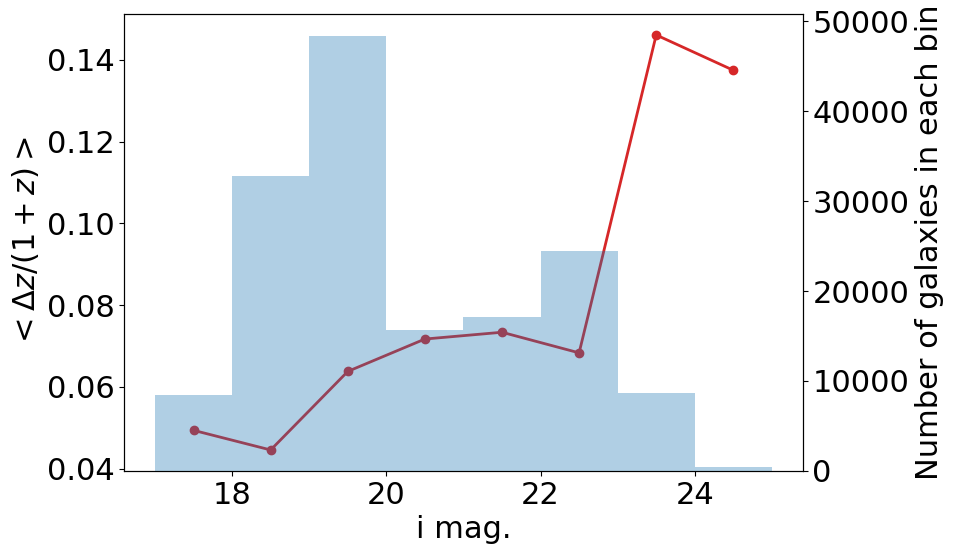

In [44]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(4, 3), dpi=80)

result_table = Table.read('meandz_vs_r.csv')

# Центры r-бинов
r_mid = 0.5 * (result_table['r_min'] + result_table['r_max'])
meandz = result_table['meandz']
Ngal = result_table['N_galaxies']

# Фигура
fig, ax1 = plt.subplots(figsize=(10, 6))


# ---- Вторая ось Y (правая) — N_galaxies ----
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel("Number of galaxies in each bin")
ax2.bar(r_mid, Ngal, width=1.0, color=color2, alpha=0.35, label="N_galaxies")
ax2.tick_params(axis='y')


# ---- Первая ось Y (левая) — meandz ----
color1 = 'tab:red'
ax1.set_xlabel("i mag.")
ax1.set_ylabel(r"$<\Delta z / (1 + z)>$")
ax1.plot(r_mid, meandz, marker='o', linestyle='-', linewidth=2, color=color1, label="meandz")
ax1.tick_params(axis='y')

plt.tight_layout()
# ---- Заголовок ----
plt.savefig('dz_imag.pdf')
plt.show()